In [8]:
import tensorflow as tf

In [9]:
import numpy as np

In [10]:
def retrieve_data(tfrecord_file):
    feature_description = {
        "global_view": tf.io.FixedLenFeature([2001], tf.float32),
        "local_view": tf.io.FixedLenFeature([201], tf.float32),
        "av_training_set": tf.io.FixedLenFeature([], tf.string),
        "kepid": tf.io.FixedLenFeature([], tf.int64),
    }

    def parse_tfrecord(example_proto):
        example = tf.io.parse_single_example(example_proto, feature_description)
        
        # Convert label to integer
        label = tf.cond(tf.equal(example["av_training_set"], tf.constant("PC")),
                        lambda: tf.constant(1, dtype=tf.int64), # Represents a planet candidate
                        lambda: tf.constant(0, dtype=tf.int64)) # Represents a false positive
        
        # Return (global, local) as features
        return (example["global_view"], example["local_view"]), label

    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.map(parse_tfrecord)
    return dataset


Label: 1
global_view.shape=TensorShape([2001])
local_view.shape=TensorShape([201])


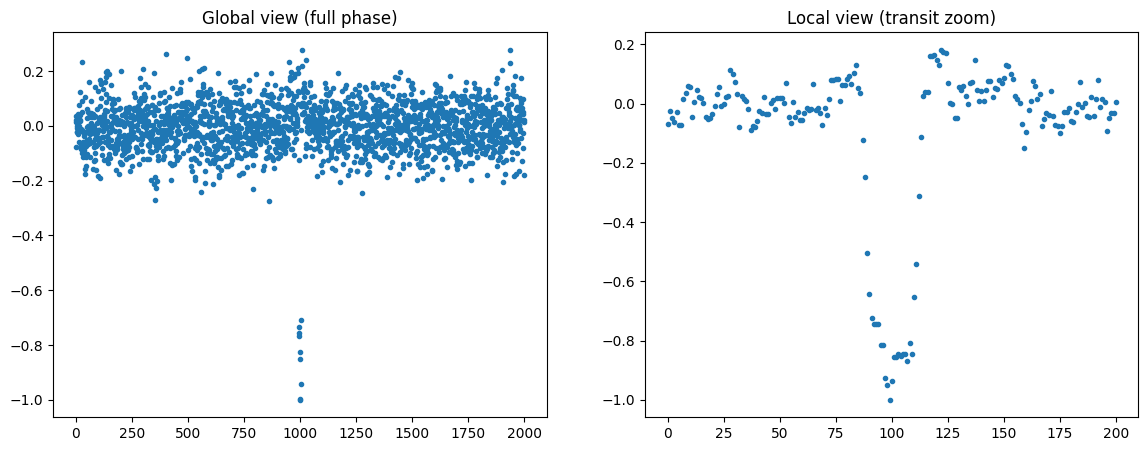

Label: 0
global_view.shape=TensorShape([2001])
local_view.shape=TensorShape([201])


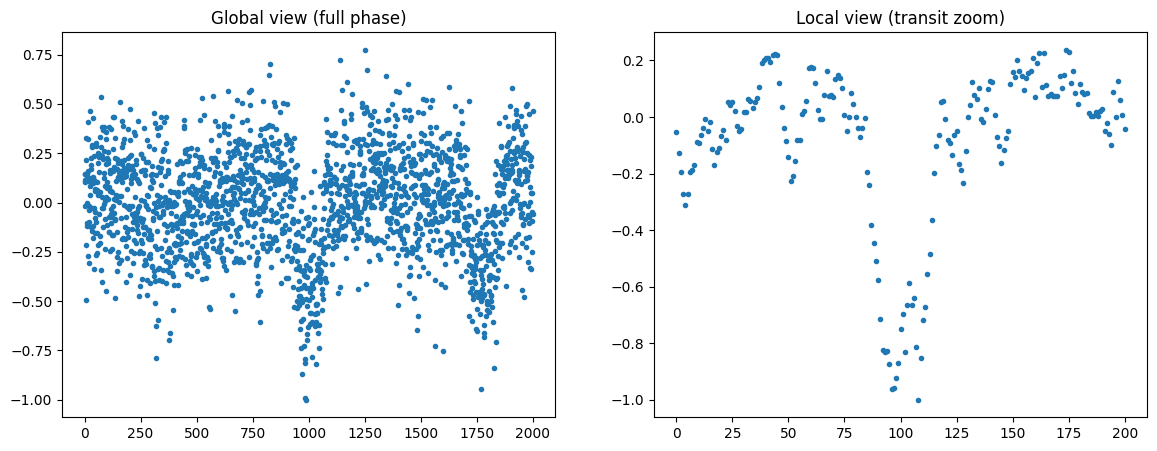

Label: 0
global_view.shape=TensorShape([2001])
local_view.shape=TensorShape([201])


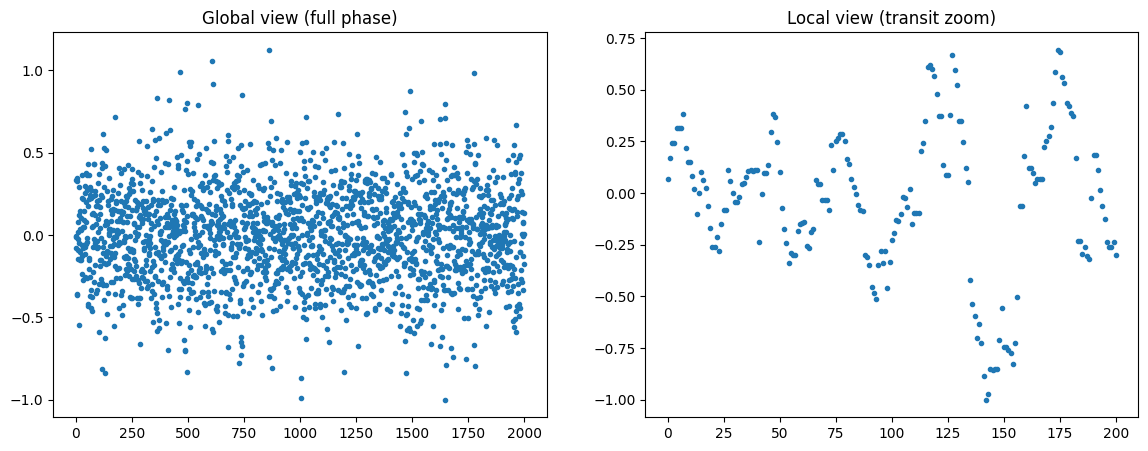

In [11]:
import matplotlib.pyplot as plt
dataset = retrieve_data("train-00000-of-00008")

for (global_view, local_view), label in dataset.take(3):
    print("Label:", label.numpy())
    print(f"{global_view.shape=}")
    print(f"{local_view.shape=}")

    
    plt.figure(figsize=(14,5))
    
    plt.subplot(1,2,1)
    plt.plot(global_view.numpy(), ".")
    plt.title("Global view (full phase)")
    
    plt.subplot(1,2,2)
    plt.plot(local_view.numpy(), ".")
    plt.title("Local view (transit zoom)")
    
    plt.show()


In [12]:
from tensorflow.keras import layers, models


In [13]:


input_global = layers.Input(shape=(2001,), name='global_view')
input_local = layers.Input(shape=(201,), name='local_view')

# Process each view separately
xg = layers.Dense(128, activation='relu')(input_global)
xg = layers.Dense(64, activation='relu')(xg)

xl = layers.Dense(32, activation='relu')(input_local)
xl = layers.Dense(16, activation='relu')(xl)

# Merge global + local
x = layers.concatenate([xg, xl])
x = layers.Dense(64, activation='relu')(x)
output = layers.Dense(1, activation='sigmoid')(x)

model = models.Model(inputs=[input_global, input_local], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ global_view         │ (None, 2001)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ local_view          │ (None, 201)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    256,256 │ global_view[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 32)        │      6,464 │ local_view[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 16)        │        528 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 80)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      5,184 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         65 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 276,753 (1.06 MB)

 Trainable params: 276,753 (1.06 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
X_global, X_local, y = [], [], []

for (global_view, local_view), label in dataset:
    X_global.append(global_view.numpy())
    X_local.append(local_view.numpy())
    y.append(label.numpy())

X_global = np.array(X_global)  # Shape: (num_samples, 2001)
X_local = np.array(X_local)    # Shape: (num_samples, 201)
y = np.array(y)


In [15]:
model.fit(
    {'global_view': X_global, 'local_view': X_local},
    y,
    epochs=20,
    batch_size=32,
    validation_split=0.1
)


Epoch 1/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.7746 - loss: 0.4167 - val_accuracy: 0.8101 - val_loss: 0.3458
Epoch 2/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8947 - loss: 0.2315 - val_accuracy: 0.8038 - val_loss: 0.3314
Epoch 3/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9477 - loss: 0.1263 - val_accuracy: 0.8291 - val_loss: 0.4019
Epoch 4/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9788 - loss: 0.0534 - val_accuracy: 0.8101 - val_loss: 0.4274
Epoch 5/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.9866 - loss: 0.0417 - val_accuracy: 0.8228 - val_loss: 0.5175
Epoch 6/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9887 - loss: 0.0343 - val_accuracy: 0.8228 - val_loss: 0.5574
Epoch 7/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9936 - loss: 0.0179 - val_accuracy: 0.8165 - val_loss: 0.5774
Epoch 8/20
45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9951 - loss: 0.0133 - val_accuracy: 0.8165 - val_loss:

In [16]:
dataTest = retrieve_data("test-00000-of-00001")
X_global_test, X_local_test, y_test = [], [], []

for (global_view, local_view), label in dataset:
    X_global_test.append(global_view.numpy())
    X_local_test.append(local_view.numpy())
    y_test.append(label.numpy())

X_global_test = np.array(X_global_test)  # Shape: (num_samples, 2001)
X_local_test = np.array(X_local_test)    # Shape: (num_samples, 201)
y_test = np.array(y_test)


In [17]:
loss, acc = model.evaluate({'global_view': X_global_test, 'local_view': X_local_test}, y_test)
print("Test Accuracy:", acc)


50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 499us/step - accuracy: 0.9784 - loss: 0.1173  
Test Accuracy: 0.9783852696418762
